**Importing the libraries needed** 

In [1]:
import numpy as np
import pandas as pd
import time


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import itertools
from numpy import loadtxt
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

**Connecting to google drive**

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


 
**Uploading the dataset**

In [3]:
path_data = "/content/gdrive/MyDrive/thesis/HARD.xlsx"

HARD = pd.read_excel(path_data)

In [4]:
data = HARD

**printing the first 3 rows of the data**

In [5]:
data.head(3)

,no,Hotel name,rating,user type,room type,nights,review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...


**printing the shape of the dataset nbr of row and columns**

In [6]:
print("Data contient {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Data contient 105698 lignes et 7 colonnes.


 **printing the fiels with missed values**



In [7]:
data.isnull().sum()

no            0
Hotel name    0
rating        0
user type     0
room type     0
nights        0
review        0
dtype: int64

**printing the number of the duplicated rows**

In [8]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  0 doublons dans Data.


**checking the types of the fiels in the data**

In [9]:
data.dtypes

no             int64
Hotel name    object
rating         int64
user type     object
room type     object
nights        object
review        object
dtype: object

**function for printing the pie**

In [10]:
def pie(data,col):
    labels = data[col].value_counts().keys().tolist()
    n = len(labels)
    if n==2:
        colors = ['#66b3ff', '#fb3999']
    elif n==3:
        colors = ['#66b3ff', '#fb3999', '#ffcc99']
    elif n==4:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff"]
    elif n==5:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99']
    elif n==6:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99',"#db7f23"]
    
    fig1, f1 = plt.subplots()
    f1.pie(data[col].value_counts(), labels=labels, colors = colors, autopct='%1.1f%%',shadow=False, startangle=60) 
    f1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def histo(data,col):
    plt.figure(figsize = (10, 8))
    sns.histplot(data=data, x=col, hue = data[col], fill=True)

**Counting the % of each classe**

In [11]:
data.rating.value_counts(normalize = True)

2    0.363933
4    0.250241
5    0.249759
1    0.136067
Name: rating, dtype: float64

**Printing the distribution of the classes**

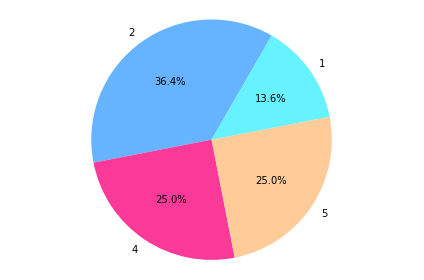

In [12]:
pie(data, "rating")

**Repartitionning the data to 2 classes**

In [13]:
positive_reviews = data[data["rating"] > 3]
positive_reviews["sentiment"] = 1

negative_reviews = data[data["rating"] < 3]
negative_reviews["sentiment"] = 0

data = pd.concat([positive_reviews, negative_reviews], ignore_index = True)

 **printing the number of rows in both classes**

In [14]:
print("data contient {} lignes.".format(data.shape[0]))

print("Positive_reviews contient {} lignes.".format(positive_reviews.shape[0]))

print("Negative_reviews contient {} lignes.".format(negative_reviews.shape[0]))

data contient 105698 lignes.
Positive_reviews contient 52849 lignes.
Negative_reviews contient 52849 lignes.


**printing the new distribution of the data**

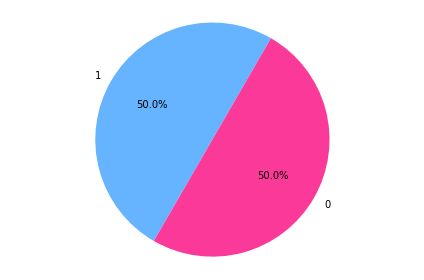

In [15]:
pie(data,"sentiment")

**printing the new distribution in histogramme**

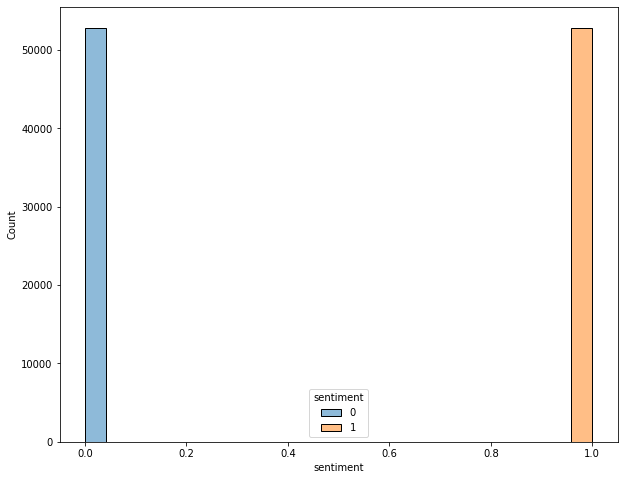

In [16]:
histo(data,"sentiment")

**function to count the length of reviews**



In [17]:
def compte_mots(phrase):
    return len(phrase.split())

data["len_review"] = data["review"].apply(compte_mots)
positive_reviews['len_review'] = positive_reviews["review"].apply(compte_mots)
negative_reviews['len_review'] = negative_reviews["review"].apply(compte_mots)

**printing the max  length of the positive and negative reviews**

In [18]:
print("Le maximum de mots utilisé dans les reviews positives est :", max(positive_reviews.len_review))
print("Le moyen de mots utilisé dans les reviews positives est :", np.mean(positive_reviews.len_review))
print("-------------------------------------------------------------------------------------------------------")
print("Le maximum de mots utilisé dans les reviews négatives est :", max(negative_reviews.len_review))
print("Le moyen de mots utilisé dans les reviews négatives est :", np.mean(negative_reviews.len_review))

Le maximum de mots utilisé dans les reviews positives est : 570
Le moyen de mots utilisé dans les reviews positives est : 19.829703494862724
-------------------------------------------------------------------------------------------------------
Le maximum de mots utilisé dans les reviews négatives est : 614
Le moyen de mots utilisé dans les reviews négatives est : 28.094722700524134


(0.0, 200.0)

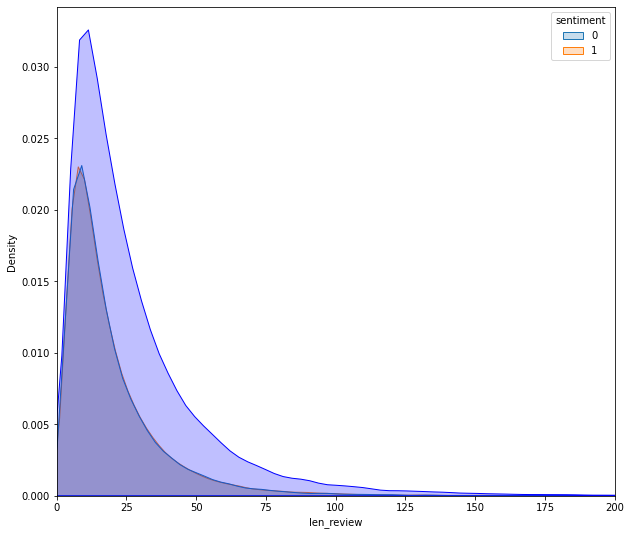

In [19]:
plt.figure(figsize=(10,9))

p1=sns.kdeplot(positive_reviews['len_review'], hue = data['sentiment'],  shade=True, color="r")
p1=sns.kdeplot(negative_reviews['len_review'], shade=True, color="b")

plt.xlim(0, 200)

**Deleting unused fields**

In [20]:
data.drop(['no','Hotel name','rating','user type','room type','nights'], axis = 1, inplace = True)
data.head(3)

,review,sentiment,len_review
0,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...,1,7
1,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...,1,11
2,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...,1,23


In [21]:
df = data

**the function of the preprocessing**

In [22]:
def preprocessing(x):
    x = re.sub('@[^\s]+', ' ', x)
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',x)
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030""]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', x)
    
    ar_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ#'''
    en_punctuations = string.punctuation
    punctuations = ar_punctuations + en_punctuations
    x = x.translate(str.maketrans('', '', punctuations))
 
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    x = re.sub(arabic_diacritics, '', str(x)) 
    
#     x = re.sub("[إأآا]", "ا", x)
#     x = re.sub("ى", "ي", x)
#     x = re.sub("ة", "ه", x)
#     x = re.sub("گ", "ك", x)
#     x = re.sub(r'(.)\1+', r'\1', x)
    
    return x



**preprocessing the reviews and printing the time spent**

In [23]:
%%time
data["Clean_reviews"] = data.review.apply(lambda x: preprocessing(x))

CPU times: user 3.07 s, sys: 24.6 ms, total: 3.1 s
Wall time: 3.11 s


**printing a review before and after preprocessing**

In [24]:
print('- Avant le prétraitement \n\n',data["review"][4])
print("\n-----------------------------------------------\n")
print('- Après le prétraitement \n\n',data["Clean_reviews"][4])

- Avant le prétraitement 

 “جيدجداً”. الافطار جيد والسرير ممتاز ومريح واطلالة الغرفة رائعه. فرش ارضية الغرفه

-----------------------------------------------

- Après le prétraitement 

 جيدجدا الافطار جيد والسرير ممتاز ومريح واطلالة الغرفة رائعه فرش ارضية الغرفه


**Saving the cleaned data in a csv file**

In [25]:
data.to_csv("cleaned_hard.csv")

**asigning the reviews and classes to a new variables**




In [26]:
X = data.Clean_reviews
y = data.sentiment

**spliting the data to train and test set**



In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

**printing the number of the train set and the test set**

In [28]:
print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (84558,)
Test set (21140,)


In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Uploading the fsttext pretrained word embedding with 150 dimension**

In [30]:
%%time
target_word_vec = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/thesis/cc.ar.150.vec", binary = False)

CPU times: user 2min 28s, sys: 4.14 s, total: 2min 33s
Wall time: 3min 1s


**tokenization of the reviews**

In [31]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

CPU times: user 3 s, sys: 34 ms, total: 3.03 s
Wall time: 3.04 s


In [32]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

**making all reviews of the same length 615**

In [33]:
%%time
MAX_SEQUENCE_LENGTH = 615

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", X_train.shape)
print("Testing X Shape:", X_test.shape)

Training X Shape: (84558, 615)
Testing X Shape: (21140, 615)
CPU times: user 3.19 s, sys: 131 ms, total: 3.32 s
Wall time: 3.32 s


**Construction of the embedding matrix**

In [34]:
%%time
embedding_matrix = np.zeros((vocab_size, 150))

for word, i in word_index.items():
    if word in target_word_vec :
        embedding_vector = target_word_vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

CPU times: user 316 ms, sys: 64.1 ms, total: 380 ms
Wall time: 381 ms


In [35]:
embedding_matrix.shape[0] == vocab_size

True

**Creating the model**

In [36]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            150, 
                            weights = [embedding_matrix], 
                            input_length = MAX_SEQUENCE_LENGTH, 
                            trainable=False)
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 615, 150)          19810200  
                                                                 
 conv1d (Conv1D)             (None, 614, 64)           19264     
                                                                 
 bidirectional (Bidirectiona  (None, 614, 128)         66048     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

**fitting the model to the dataset**

In [37]:
history = model.fit(X_train, y_train, validation_split=0.15, batch_size = 128, epochs=20, verbose=1, callbacks=[es])

Epoch 1/20
71/71 [==============================] - 36s 278ms/step - loss: 0.4763 - accuracy: 0.7705 - val_loss: 0.2490 - val_accuracy: 0.9096
Epoch 2/20
71/71 [==============================] - 19s 269ms/step - loss: 0.2275 - accuracy: 0.9195 - val_loss: 0.1933 - val_accuracy: 0.9313
Epoch 3/20
71/71 [==============================] - 19s 274ms/step - loss: 0.1977 - accuracy: 0.9297 - val_loss: 0.1801 - val_accuracy: 0.9359
Epoch 4/20
71/71 [==============================] - 20s 277ms/step - loss: 0.1851 - accuracy: 0.9346 - val_loss: 0.1695 - val_accuracy: 0.9397
Epoch 5/20
71/71 [==============================] - 20s 282ms/step - loss: 0.1784 - accuracy: 0.9376 - val_loss: 0.1665 - val_accuracy: 0.9406
Epoch 6/20
71/71 [==============================] - 20s 281ms/step - loss: 0.1718 - accuracy: 0.9404 - val_loss: 0.1613 - val_accuracy: 0.9414
Epoch 7/20
71/71 [==============================] - 20s 278ms/step - loss: 0.1658 - accuracy: 0.9421 - val_loss: 0.1574 - val_accuracy: 0.9445

**Evaluating the model**

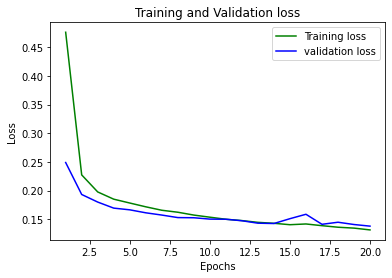

In [38]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

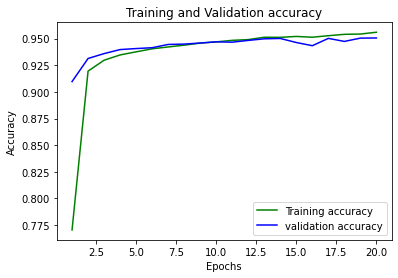

In [39]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

661/661 [==============================] - 12s 18ms/step - loss: 0.1436 - accuracy: 0.9493
accuracy: 94.93%


In [41]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [42]:
scores = model.predict(X_test, verbose=1)

y_pred = [decode_sentiment(x) for x in scores]

661/661 [==============================] - 13s 18ms/step


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10600
           1       0.94      0.96      0.95     10540

    accuracy                           0.95     21140
   macro avg       0.95      0.95      0.95     21140
weighted avg       0.95      0.95      0.95     21140



**function for creating confusion matrix**

In [44]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

**printing the confusion matrix**

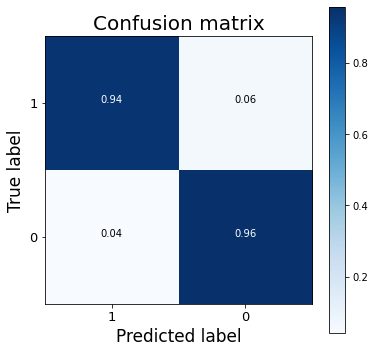

In [45]:
cnf_matrix = confusion_matrix(y_test.to_list(), y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()